In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/src/filtered.csv')

In [3]:
df

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation,no_of_visits,is_confirmed,step_duration,time_in_min,no_of_confirms,had_error,error_count
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Test,2,True,0 days 00:03:46,3.766667,3,False,0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Control,1,True,0 days 00:00:59,0.983333,1,False,0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,Test,2,False,0 days 00:00:39,0.650000,0,True,1
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Test,1,False,0,0.000000,0,False,0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Control,1,False,0,0.000000,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50480,1780858,21.0,262.0,68.5,M,3.0,372100.59,6.0,9.0,Test,2,True,0 days 00:01:29.400000,1.490000,2,False,0
50481,6967120,21.0,260.0,68.5,M,3.0,4279873.38,6.0,9.0,Control,1,True,0 days 00:00:49.750000,0.829167,1,False,0
50482,5826160,20.0,249.0,56.5,F,2.0,44837.16,2.0,5.0,Test,3,True,0 days 00:01:35,1.583333,6,False,0
50483,8739285,19.0,229.0,69.5,F,2.0,44994.24,1.0,4.0,Test,1,True,0 days 00:02:53,2.883333,1,False,0


## Completion Rate: The proportion of users who reach the final ‘confirm’ step.

In [4]:
crosstab_corr = pd.crosstab(index=df['Variation'], columns=df['is_confirmed'])
crosstab_corr['Total_nr_of_clients'] = df['Variation'].value_counts(ascending=True)
crosstab_corr['% of_confirmed'] = round(crosstab_corr[True]/crosstab_corr['Total_nr_of_clients']*100, 2)
crosstab_corr.drop(False, axis=1, inplace=True)
crosstab_corr.columns = ['Nr_of_confirmed', 'Total_nr_of_clients', '%_of_confirmed']

In [5]:
crosstab_corr

,Nr_of_confirmed,Total_nr_of_clients,%_of_confirmed
Variation,,,
Control,15428,23526,65.58
Test,18682,26959,69.30


**1. p-value test and initial statistics** 

Null hypothesis: 'Test' and 'Control' groups have the same proportion of users who reached the final 'confirm' step (no statistical difference between groups)

In [6]:
control = df[df['Variation']=='Control']
test = df[df['Variation']=='Test']
stats.ttest_ind(control['is_confirmed'], test['is_confirmed']).pvalue

5.178761560302029e-19

- p-value practically zero => we can reject null hypothesis - there is statistically significant difference between 'Test' and 'Control' groups

- 66.6% of 'Control' group and 69.3% of 'Test' group has reached the confirmation step

In [7]:
df_stats = df['is_confirmed'].astype(int).describe()
test_stats = test['is_confirmed'].astype(int).describe()
control_stats = control['is_confirmed'].astype(int).describe()

stast_summary = pd.DataFrame({'Control': control_stats, 'Test': test_stats, 'Total': df_stats })

stast_summary

,Control,Test,Total
count,23526.000000,26959.000000,50485.000000
mean,0.655785,0.692978,0.675646
std,0.475122,0.461267,0.468138
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


**1.2. Nr of confirmation per age group**

In [8]:
#Categorization of ages by bins of ages :
bin_edges = [0, 18, 25, 35, 45, 55, 65, float('inf')]
bin_labels = ['<18yrs', '18-25yrs', '25-35yrs', '35-45yrs', '45-55yrs', '55-65yrs', '>65yrs']

df['age_bin'] = pd.cut(df['clnt_age'], bins=bin_edges, labels=bin_labels, right=False)

In [9]:
#Number of confirms in each age group

age_confirms = df.groupby(['Variation', 'age_bin'])['is_confirmed'].sum().unstack(level=0) #nr of confirms
age_confirms.columns = ['Control_nr_conf', 'Test_nr_conf']

In [10]:
#Total nr of people in each age group

age_total_number = df.groupby(['Variation', 'age_bin'])['is_confirmed'].count().unstack(level=0)
age_total_number.columns = ['Control_total_nr', 'Test_total_nr']

In [11]:
# Join age_confirms and age_total_number into one table and calculate percentages

confirmations_per_age = age_confirms.join(age_total_number, on=age_confirms.index)
confirmations_per_age['%_conf_of_Control'] = round(confirmations_per_age['Control_nr_conf'] / confirmations_per_age['Control_total_nr'] *100, 2)
confirmations_per_age['%_conf_of_Test'] = round(confirmations_per_age['Test_nr_conf'] / confirmations_per_age['Test_total_nr'] *100, 2)

In [12]:
confirmations_per_age

,Control_nr_conf,Test_nr_conf,Control_total_nr,Test_total_nr,%_conf_of_Control,%_conf_of_Test
age_bin,,,,,,
<18yrs,28,34,28,34,100.00,100.00
18-25yrs,1017,1332,1484,1797,68.53,74.12
25-35yrs,3252,4097,4846,5686,67.11,72.05
35-45yrs,2666,3217,3953,4565,67.44,70.47
45-55yrs,3081,3658,4586,5296,67.18,69.07
55-65yrs,3389,3930,5112,5691,66.29,69.06
>65yrs,1995,2414,3517,3890,56.72,62.06


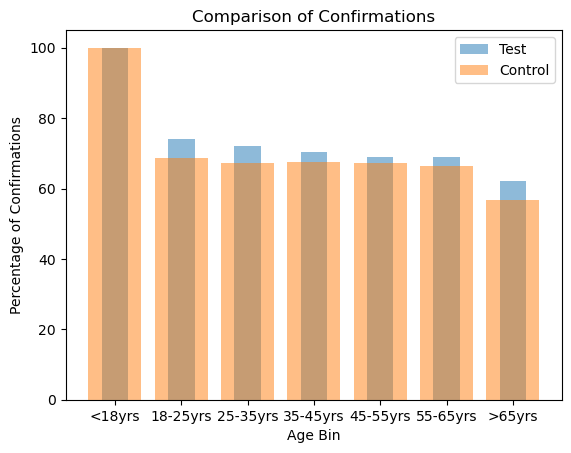

In [13]:
# Create a bar plot using Matplotlib
plt.bar(confirmations_per_age.index, confirmations_per_age['%_conf_of_Test'], label='Test', alpha=0.5, width=0.4)
plt.bar(confirmations_per_age.index, confirmations_per_age['%_conf_of_Control'], label='Control', alpha=0.5, width=0.8)


# Customize the plot
plt.title('Comparison of Confirmations')
plt.xlabel('Age Bin')
plt.ylabel('Percentage of Confirmations')
plt.legend()

# Show the plot
plt.show()

Text(0, 0.5, 'Sum of is_confirmed')

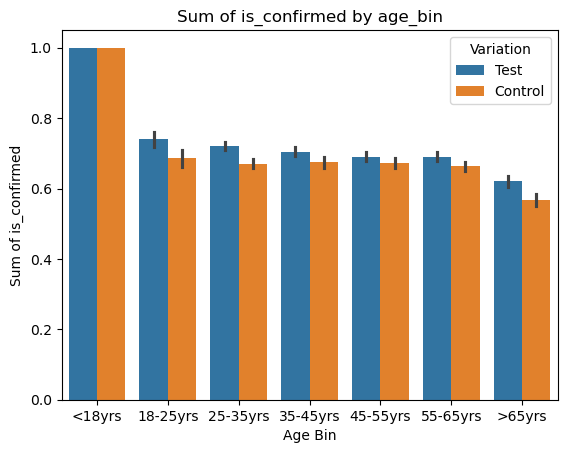

In [14]:
# Create a barplot with comparison of mean

sns.barplot(x=df['age_bin'], y=df['is_confirmed'].astype(int),  hue=df['Variation'])

# Customize the plot
plt.title('Sum of is_confirmed by age_bin')
plt.xlabel('Age Bin')
plt.ylabel('Sum of is_confirmed')

**1.3. Nr of confirmation based on old/new customers**

In [15]:
# #Categorization of ages by bins of ages :
bin_edges_tenure = [0, 2, 5, 10, 20, 30, 40, float('inf')]
bin_labels_tenure = ['2yrs', '3-5yrs', '6-10yrs', '11-20yrs', '21-30yrs', '31-40yrs', '>41yrs']

df['tenure_yr_bin'] = pd.cut(df['clnt_tenure_yr'], bins=bin_edges_tenure, labels=bin_labels_tenure, right=True)

In [16]:
df

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation,no_of_visits,is_confirmed,step_duration,time_in_min,no_of_confirms,had_error,error_count,age_bin,tenure_yr_bin
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Test,2,True,0 days 00:03:46,3.766667,3,False,0,55-65yrs,6-10yrs
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Control,1,True,0 days 00:00:59,0.983333,1,False,0,55-65yrs,6-10yrs
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,Test,2,False,0 days 00:00:39,0.650000,0,True,1,25-35yrs,3-5yrs
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Test,1,False,0,0.000000,0,False,0,45-55yrs,11-20yrs
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Control,1,False,0,0.000000,0,False,0,25-35yrs,11-20yrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50480,1780858,21.0,262.0,68.5,M,3.0,372100.59,6.0,9.0,Test,2,True,0 days 00:01:29.400000,1.490000,2,False,0,>65yrs,21-30yrs
50481,6967120,21.0,260.0,68.5,M,3.0,4279873.38,6.0,9.0,Control,1,True,0 days 00:00:49.750000,0.829167,1,False,0,>65yrs,21-30yrs
50482,5826160,20.0,249.0,56.5,F,2.0,44837.16,2.0,5.0,Test,3,True,0 days 00:01:35,1.583333,6,False,0,55-65yrs,11-20yrs
50483,8739285,19.0,229.0,69.5,F,2.0,44994.24,1.0,4.0,Test,1,True,0 days 00:02:53,2.883333,1,False,0,>65yrs,11-20yrs


In [17]:
df['tenure_yr_bin'].value_counts()

tenure_yr_bin
11-20yrs    18818
6-10yrs     15974
3-5yrs       8668
21-30yrs     6249
31-40yrs      663
2yrs           61
>41yrs         52
Name: count, dtype: int64

In [18]:
# df[(df['clnt_age'] - df['clnt_tenure_yr'] < 0)]   #['clnt_tenure_yr'].value_counts()

Text(0, 0.5, 'Sum of is_confirmed')

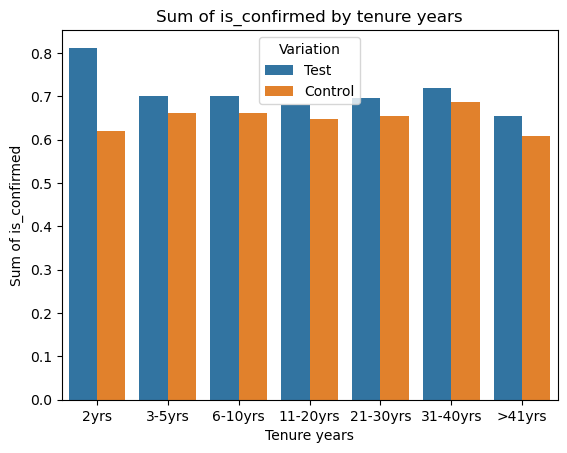

In [19]:
# Create a barplot with comparison of mean

sns.barplot(x=df['tenure_yr_bin'], y=df['is_confirmed'].astype(int),  hue=df['Variation'], errorbar=None)

# Customize the plot
plt.title('Sum of is_confirmed by tenure years')
plt.xlabel('Tenure years')
plt.ylabel('Sum of is_confirmed')

Text(0, 0.5, 'Sum of is_confirmed')

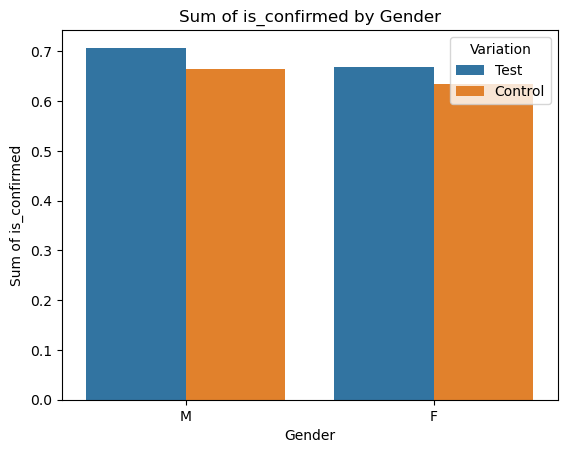

In [20]:
# Create a barplot with comparison of mean

sns.barplot(x=df[df['gendr'].isin(['M', 'F'])]['gendr'], y=df['is_confirmed'].astype(int),  hue=df['Variation'], errorbar=None)

# Customize the plot
plt.title('Sum of is_confirmed by Gender')
plt.xlabel('Gender')
plt.ylabel('Sum of is_confirmed')

In [21]:
df

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation,no_of_visits,is_confirmed,step_duration,time_in_min,no_of_confirms,had_error,error_count,age_bin,tenure_yr_bin
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Test,2,True,0 days 00:03:46,3.766667,3,False,0,55-65yrs,6-10yrs
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Control,1,True,0 days 00:00:59,0.983333,1,False,0,55-65yrs,6-10yrs
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,Test,2,False,0 days 00:00:39,0.650000,0,True,1,25-35yrs,3-5yrs
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Test,1,False,0,0.000000,0,False,0,45-55yrs,11-20yrs
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Control,1,False,0,0.000000,0,False,0,25-35yrs,11-20yrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50480,1780858,21.0,262.0,68.5,M,3.0,372100.59,6.0,9.0,Test,2,True,0 days 00:01:29.400000,1.490000,2,False,0,>65yrs,21-30yrs
50481,6967120,21.0,260.0,68.5,M,3.0,4279873.38,6.0,9.0,Control,1,True,0 days 00:00:49.750000,0.829167,1,False,0,>65yrs,21-30yrs
50482,5826160,20.0,249.0,56.5,F,2.0,44837.16,2.0,5.0,Test,3,True,0 days 00:01:35,1.583333,6,False,0,55-65yrs,11-20yrs
50483,8739285,19.0,229.0,69.5,F,2.0,44994.24,1.0,4.0,Test,1,True,0 days 00:02:53,2.883333,1,False,0,>65yrs,11-20yrs
